# 1. Import Required Libraries

In [20]:
# Data manipulation
import pandas as pd 
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

import xgboost as xgb  # ML algorithm for forecasting
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error  # Error metrics
from sklearn.model_selection import train_test_split #Splitting data
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit #hyperparameter tuning

from statsmodels.tsa.seasonal import seasonal_decompose, STL #Decomposition of time series

from scipy.stats import spearmanr, chi2_contingency

In [21]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(10, 4), 
                     use_date_locator=True, title=None):
  fig, ax = plt.subplots(figsize=figsize)

  ax.plot(x, y)

  if use_date_locator:
    formatter = mdates.DateFormatter("%Y-%b")
    # locator = mdates.YearLocator(base=2)
    locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 3, 2))
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(locator)
  

  ax.grid("on")
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  if title is not None:
    ax.set_title(title)

  if use_date_locator:
    for j, label in enumerate(ax.get_xticklabels()):
      label.set_rotation(40)
      label.set_horizontalalignment('right')

  plt.show(fig)

In [22]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 16,
  'grid.alpha': 0.25})

# 2. Load the Data

In [23]:
df = pd.read_csv("../dataset/common_diseases.csv")

In [24]:
df.head()

,Date,Disease,Frequency,Average Age,StdDev Age,Subdistrict
0,2015-01-06,J18.0,1,10.0,0.0,5
1,2015-01-12,J18.0,1,6.0,0.0,5
2,2015-01-19,J18.0,1,1.0,0.0,4
3,2015-01-23,J18.0,1,3.0,0.0,2
4,2015-01-26,J18.0,1,56.0,0.0,3


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24672 entries, 0 to 24671
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         24672 non-null  object 
 1   Disease      24672 non-null  object 
 2   Frequency    24672 non-null  int64  
 3   Average Age  24672 non-null  float64
 4   StdDev Age   24672 non-null  float64
 5   Subdistrict  24672 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 1.1+ MB


In [26]:
print('dataset ini mengandung {} baris dan {} kolom'. format(df.shape[0], df.shape[1]))

dataset ini mengandung 24672 baris dan 6 kolom


# 3. Data Cleaning

Mengubah format date menjadi datetime 

In [27]:
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

Mengambil penyakit tertentu yaitu E11 untuk diproses lebih lanjut

In [28]:
df_A09 = df[df["Disease"] == "A09"]

uniform_index = pd.date_range(start=df_A09.index.min(), end=df_A09.index.max(), freq="D")
df_A09 = df_A09.reindex(uniform_index)
df_A09.index.name = "Date"

df_A09

,Disease,Frequency,Average Age,StdDev Age,Subdistrict
Date,,,,,
2015-01-01,A09,3.0,25.666667,19.618585,4.0
2015-01-02,A09,3.0,15.000000,14.236104,4.0
2015-01-03,NaN,NaN,NaN,NaN,NaN
2015-01-04,A09,2.0,49.500000,1.500000,5.0
2015-01-05,A09,1.0,13.000000,0.000000,4.0
...,...,...,...,...,...
2024-12-23,NaN,NaN,NaN,NaN,NaN
2024-12-24,A09,3.0,1.000000,1.414214,6.0
2024-12-25,NaN,NaN,NaN,NaN,NaN


In [29]:
# cek apakah ada nilai null (kosong atau NaN)
print(df_A09.isnull().sum())

Disease        1337
Frequency      1337
Average Age    1337
StdDev Age     1337
Subdistrict    1337
dtype: int64


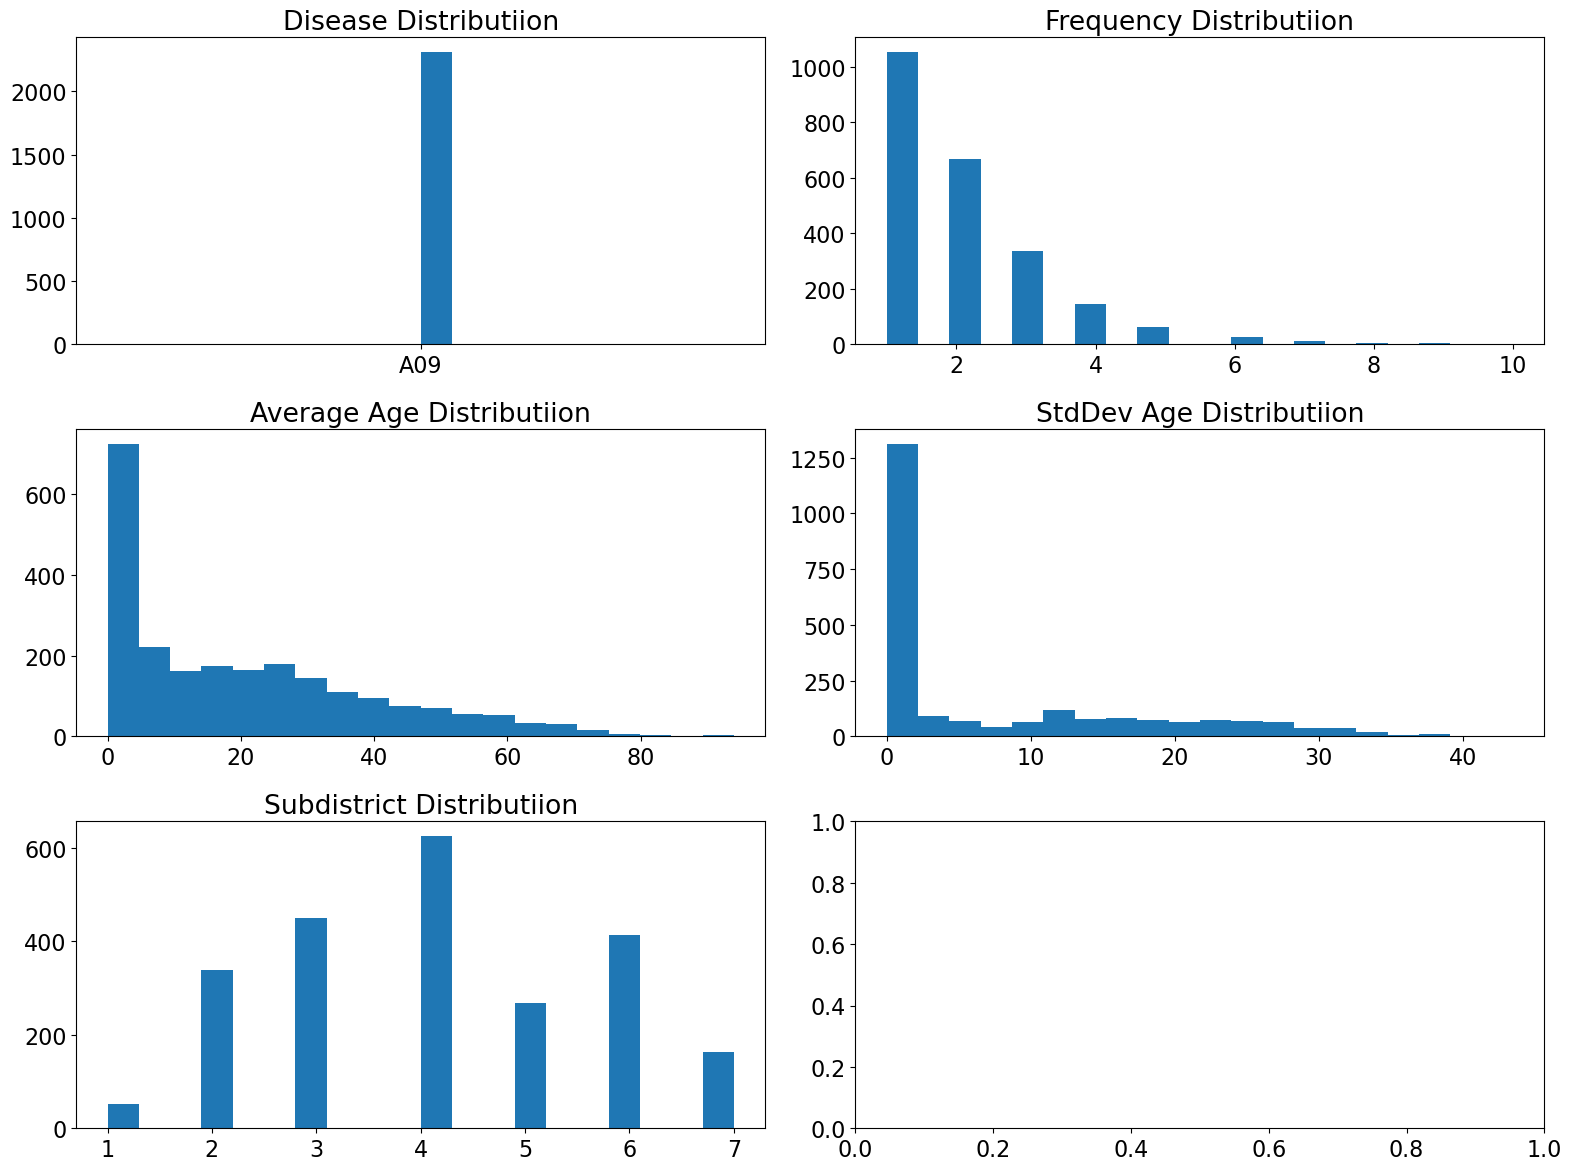

In [30]:
# df_E11 = df_E11.apply(pd.to_numeric, errors='coerce')

fig, axs = plt.subplots(3,2, figsize = (16,12))
axs = axs.ravel()

for i, column in enumerate(df_A09.columns):
    axs[i].hist(df_A09[column].dropna(), bins = 20)
    axs[i].set_title('{} Distributiion'.format(column))

plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()

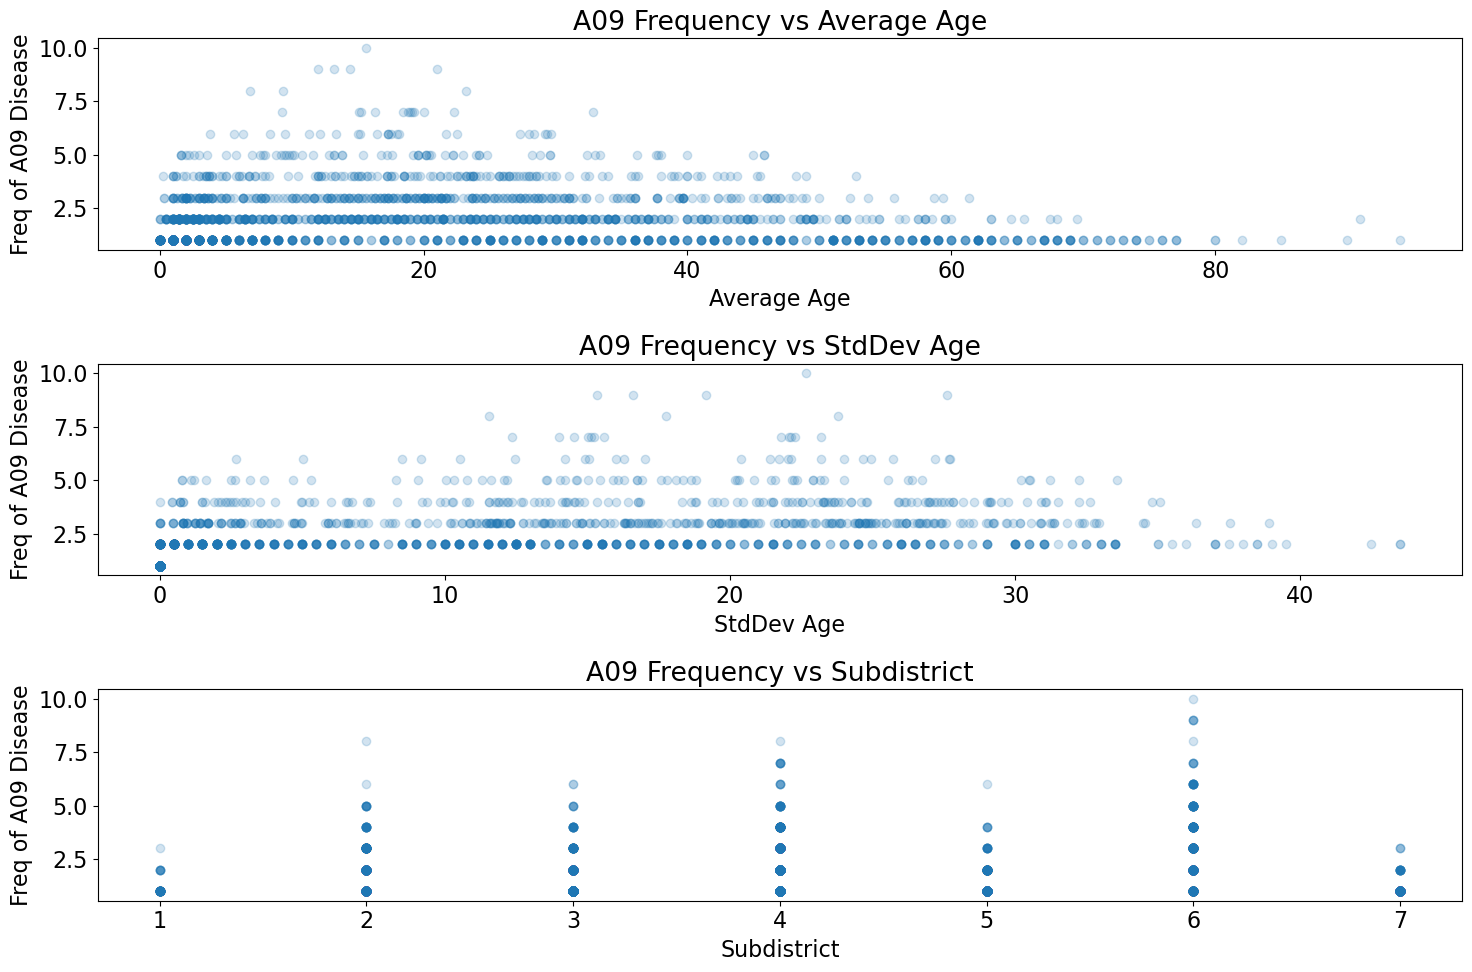

In [31]:
plot = df_A09.copy()
plot = plot.dropna(axis=1, how='all')  # Hapus kolom yang semua isinya NaN
plot = plot.dropna()

selected_columns = ['Average Age', 'StdDev Age', 'Subdistrict']
fig, axs = plt.subplots(3,1, figsize = (15,10), dpi=100)
axs = axs.ravel()

for i, column in enumerate(selected_columns):
    axs[i].scatter(plot[column], plot["Frequency"], alpha = 0.2) # diagram sebaran dengan jenis grafik 'scatter'
    axs[i].set_xlabel(column)
    axs[i].set_ylabel("Freq of A09 Disease")
    axs[i].set_title('A09 Frequency vs {}'.format(column))
    
plt.subplots_adjust(hspace=0.5)

plt.tight_layout()
plt.show()

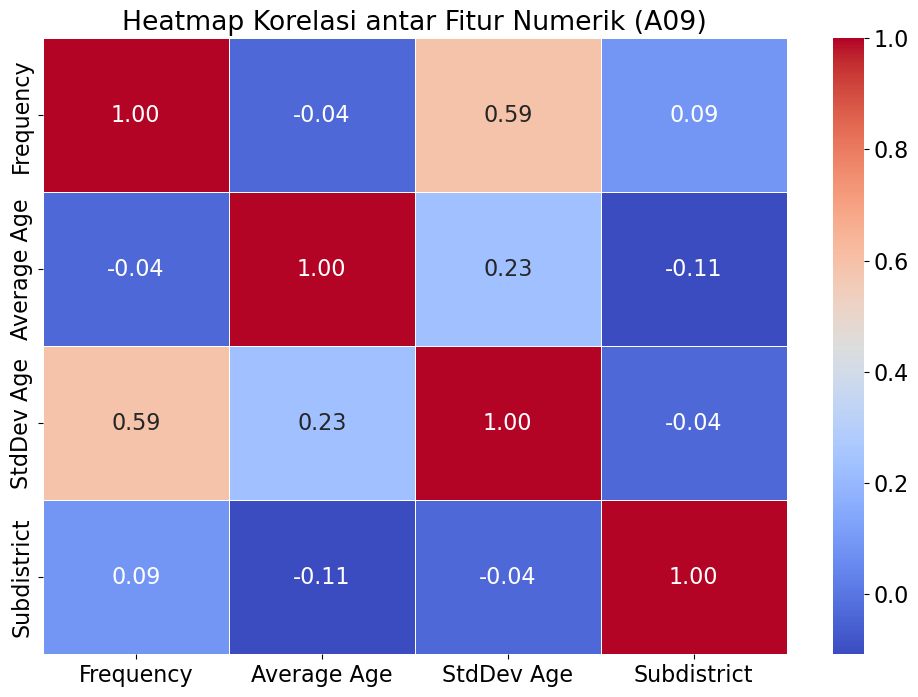

In [32]:
plot = df_A09.copy()
plot = plot.dropna(axis=1, how='all')
plot = plot.dropna()

plot_numeric = plot.select_dtypes(include='number')

correlation_matrix = plot_numeric.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap Korelasi antar Fitur Numerik (A09)")
plt.show()


Uji korelasi dengan Spearman/Pearson

In [33]:
df_uji = df_A09.copy()
results = []

# uji spearman untuk fitur numerik
numeric_cols = ['Average Age', 'StdDev Age']
for col in numeric_cols:
    rs, p = spearmanr(df_uji[col], df_uji['Frequency'], nan_policy='omit')
    results.append({
        'Feature': col,
        'Test': 'Spearman',
        'Statistic': rs,
        'p_value': p
    })

# uji chi-square untuk fitur kategorikal: Subdistrict vs Frequency
df_uji['Frequency_bin'] = pd.qcut(df_uji['Frequency'], q=4, duplicates='drop') #variabel freq diubah dulu ke kategori (binned)

contingency = pd.crosstab(df_uji['Subdistrict'], df_uji['Frequency_bin'])
chi2, p, dof, expected = chi2_contingency(contingency)

results.append({
    'Feature': 'Subdistrict',
    'Test': 'Chi-Square',
    'Statistic': chi2,
    'p_value': p
})

corr_df = pd.DataFrame(results)
corr_df


,Feature,Test,Statistic,p_value
0,Average Age,Spearman,0.104045,5.338782e-07
1,StdDev Age,Spearman,0.856244,0.000000e+00
2,Subdistrict,Chi-Square,320.174912,2.698970e-61


# 4. Exploratory Data Analysis

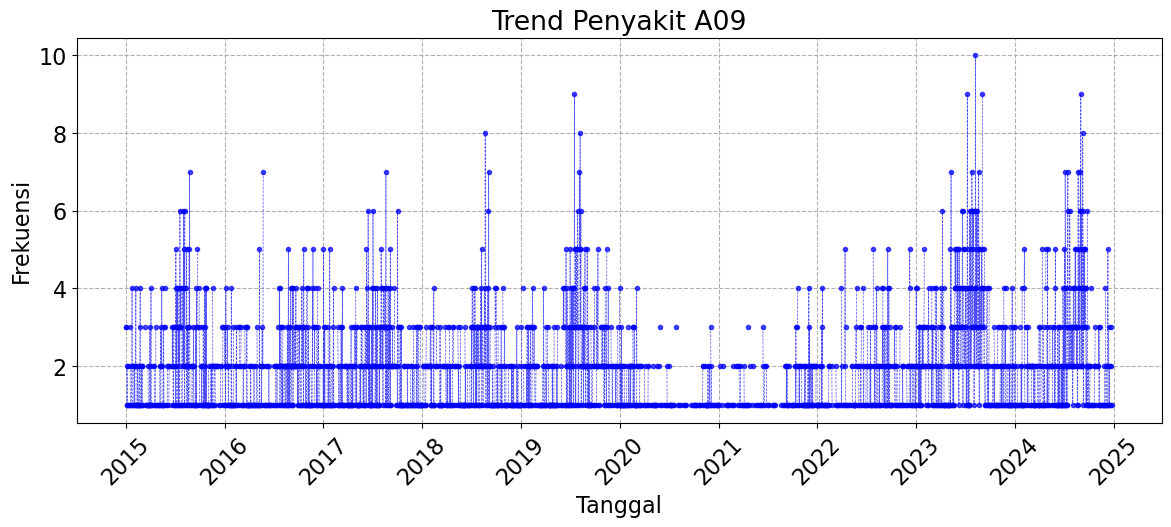

In [34]:
df = df_A09.copy() 

df.index = pd.to_datetime(df.index)

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(df.index, df["Frequency"], 
    marker="o", markersize=3, linestyle="dashed", 
    color="blue", alpha=0.7, linewidth=0.5)

plt.xticks(rotation=45)

ax.set_title("Trend Penyakit A09")
ax.set_xlabel("Tanggal")
ax.set_ylabel("Frekuensi")
ax.grid(True, linestyle="--", alpha=1)

plt.show()

### Day Of Week

In [35]:
data_daily = df_A09.resample("D").sum()
data_daily.head()

,Disease,Frequency,Average Age,StdDev Age,Subdistrict
Date,,,,,
2015-01-01,A09,3.0,25.666667,19.618585,4.0
2015-01-02,A09,3.0,15.000000,14.236104,4.0
2015-01-03,0,0.0,0.000000,0.000000,0.0
2015-01-04,A09,2.0,49.500000,1.500000,5.0
2015-01-05,A09,1.0,13.000000,0.000000,4.0


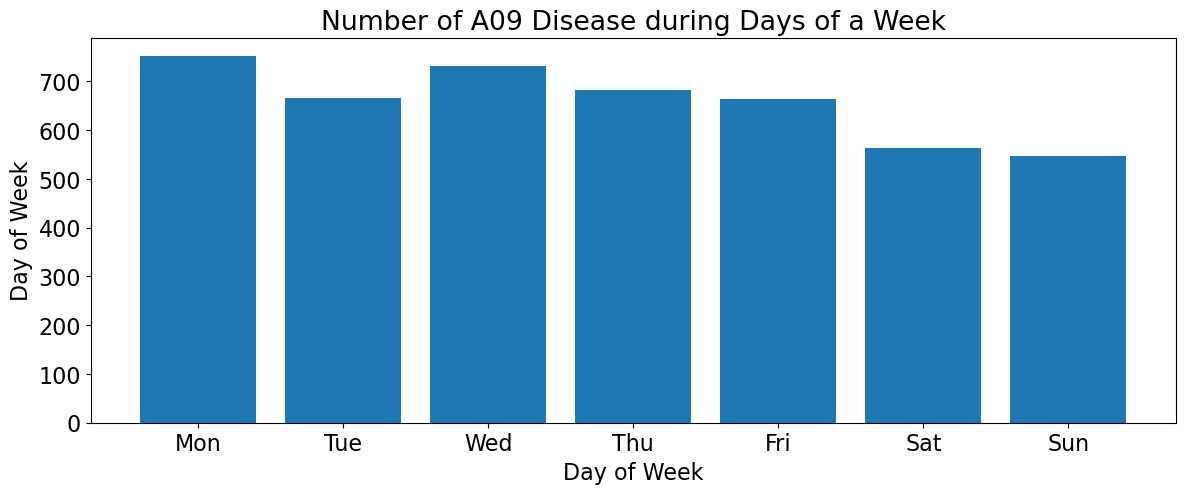

In [32]:
data_weekday = data_daily.groupby(data_daily.index.dayofweek).sum(numeric_only=True)

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(data_weekday.index, data_weekday["Frequency"])
ax.set_xticks(range(7))
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
ax.set_xlabel("Day of Week")
ax.set_ylabel("Day of Week")
ax.set_title("Number of A09 Disease during Days of a Week")
plt.show()

### 4.1 A09 Disease vs Avg Age

In [33]:
data_average = df_A09.groupby('Average Age')['Frequency'].sum()
data_average_flatten = []

for average_age, freq in zip(data_average.index.to_numpy(), data_average.values):
    for _ in range(int(freq)):
        data_average_flatten.append(average_age)
data_average_flatten = np.array(data_average_flatten)
data_average_flatten 

array([ 0.,  0.,  0., ..., 91., 91., 94.])

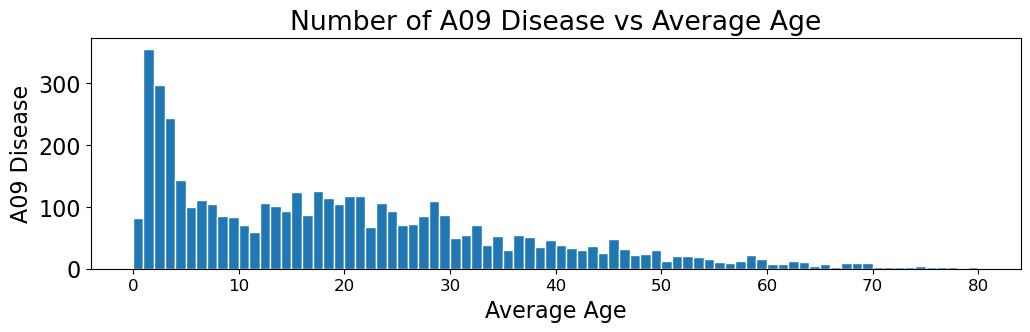

In [34]:
fig, ax = plt.subplots(figsize = (12,3))

bins = np.arange(0, 81)
ax.hist(data_average_flatten, bins=bins, edgecolor="white")
ax.set_xlabel('Average Age')
ax.set_ylabel('A09 Disease')
ax.set_title('Number of A09 Disease vs Average Age')

plt.xticks(fontsize=12)
plt.show()


### 4.2 A09 Disease vs Std Age

In [35]:
data_std = df_A09.groupby('StdDev Age')['Frequency'].sum()
data_std_flatten = []

for std_age, freq in zip(data_std.index.to_numpy(), data_std.values):
    for _ in range(int(freq)):
        data_std_flatten.append(std_age)
data_std_flatten = np.array(data_std_flatten)
data_std_flatten

array([ 0. ,  0. ,  0. , ..., 43.5, 43.5, 43.5])

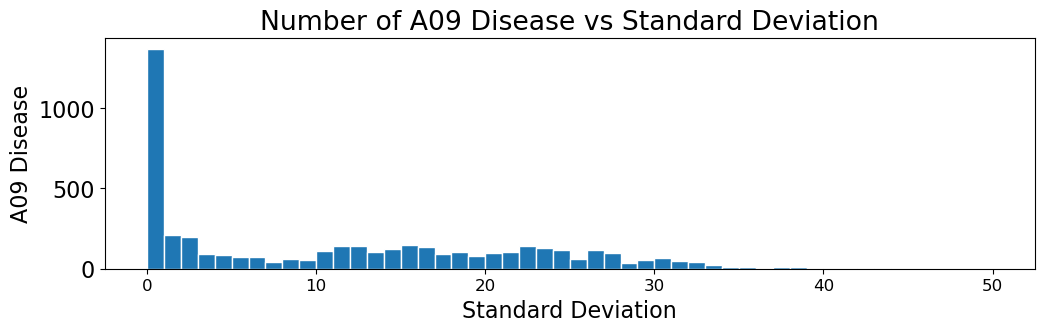

In [36]:
fig, ax = plt.subplots(figsize = (12,3))

bins = np.arange(0, 51)
ax.hist(data_std_flatten, bins=bins, edgecolor="white")
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('A09 Disease')
ax.set_title('Number of A09 Disease vs Standard Deviation')

plt.xticks(fontsize=12)
plt.show()


### 4.3 A09 Disease vs Subdistrict

- 1 = balikpapan timur
- 2 = balikpapan barat
- 3 = balikpapan utara
- 4 = balikpapan tengah
- 5 = balikpapan selatan
- 6 = balikpapan kota
- 7 = luar balikpapan

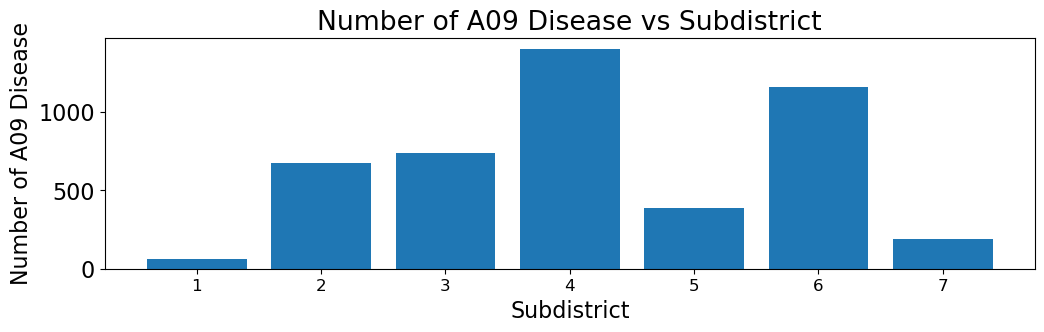

In [37]:
data_subdistrict = df_A09.groupby('Subdistrict')['Frequency'].sum()

fig, ax = plt.subplots(figsize = (12,3))

ax.bar(data_subdistrict.index, data_subdistrict.values)
ax.set_xlabel('Subdistrict')
ax.set_ylabel('Number of A09 Disease')
ax.set_title('Number of A09 Disease vs Subdistrict')

plt.xticks(fontsize=12)
plt.show()


## 4.1 Time Series Component

#### 4.1.1 `A09` Disease Daily

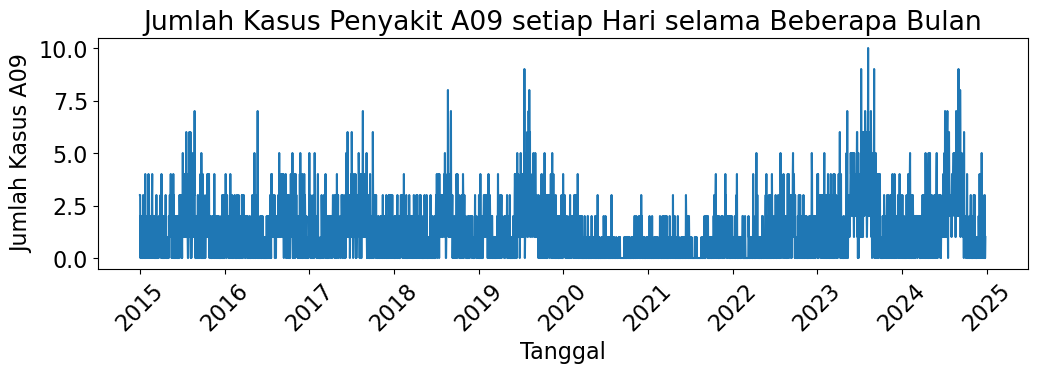

In [38]:
df_A09["Frequency"] = pd.to_numeric(df_A09["Frequency"], errors="coerce").fillna(0) 

data_daily_subset = df_A09.loc['2015-01-01':'2024-12-31']

# plot the daily counts
fig, ax = plt.subplots(figsize = (12,3))
ax.plot(data_daily_subset.index, data_daily_subset['Frequency'])

ax.set_xlabel('Tanggal')
ax.set_ylabel('Jumlah Kasus A09')
ax.set_title('Jumlah Kasus Penyakit A09 setiap Hari selama Beberapa Bulan')

ax.set_xticks(data_daily_subset.index[::30])  # Menampilkan label setiap 7 hari
ax.set_xticklabels(data_daily_subset.index[::30], rotation=45)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

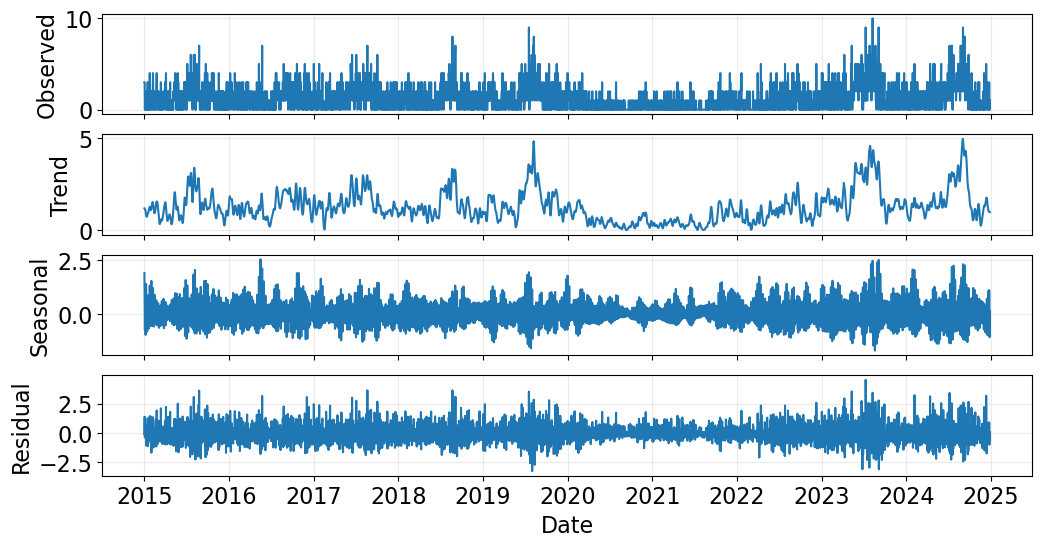

In [39]:
advanced_decomposition = STL(data_daily_subset["Frequency"], period=7).fit()
advanced_decomposition

fig, axes = plt.subplots(nrows=4, figsize=(12, 6), dpi=100, sharex=True)

axes[0].plot(data_daily_subset.index, advanced_decomposition.observed)
axes[1].plot(data_daily_subset.index, advanced_decomposition.trend)
axes[2].plot(data_daily_subset.index, advanced_decomposition.seasonal)
axes[3].plot(data_daily_subset.index, advanced_decomposition.resid)

axes[0].set_ylabel("Observed")
axes[1].set_ylabel("Trend")
axes[2].set_ylabel("Seasonal")
axes[3].set_ylabel("Residual")
axes[3].set_xlabel("Date")

for ax in axes:
  ax.grid("on")

plt.show(fig)

##### 4.1.2 `A09` Disease Weekly

In [40]:
# bikin dataframe baru yang mengubah frekuensi data menjadi mingguan
data_weekly = df_A09.resample("W").agg({
    "Disease": "first",
    "Frequency": "sum",
    "Average Age": "mean",
    "StdDev Age": "mean",
    "Subdistrict":"first"
})
data_weekly.head()

,Disease,Frequency,Average Age,StdDev Age,Subdistrict
Date,,,,,
2015-01-04,A09,8.0,30.055556,11.784897,4.0
2015-01-11,A09,5.0,25.000000,6.250000,4.0
2015-01-18,A09,7.0,12.541667,6.549918,2.0
2015-01-25,A09,9.0,13.750000,4.502034,3.0
2015-02-01,A09,6.0,29.750000,2.000000,3.0


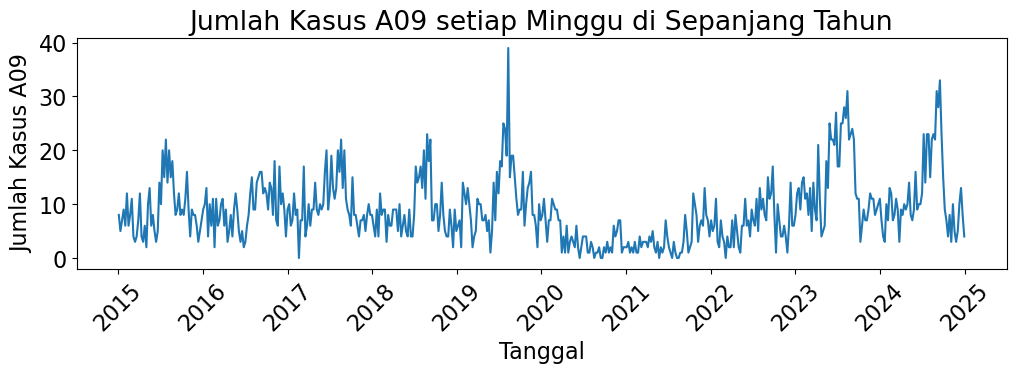

In [41]:
data_weekly_subset = data_weekly.loc['2015-01-01':'2024-12-31']

# plot the weekly counts
fig, ax = plt.subplots(figsize = (12,3))
ax.plot(data_weekly_subset.index, data_weekly_subset['Frequency'])
ax.set_xlabel('Tanggal')
ax.set_ylabel('Jumlah Kasus A09')
ax.set_title('Jumlah Kasus A09 setiap Minggu di Sepanjang Tahun')
# ax.set_xticks(data_weekly_subset.index[::2], rotation = 90)

ax.set_xticks(data_weekly_subset.index[::2])
ax.set_xticklabels(data_weekly_subset.index[::2], rotation=45)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

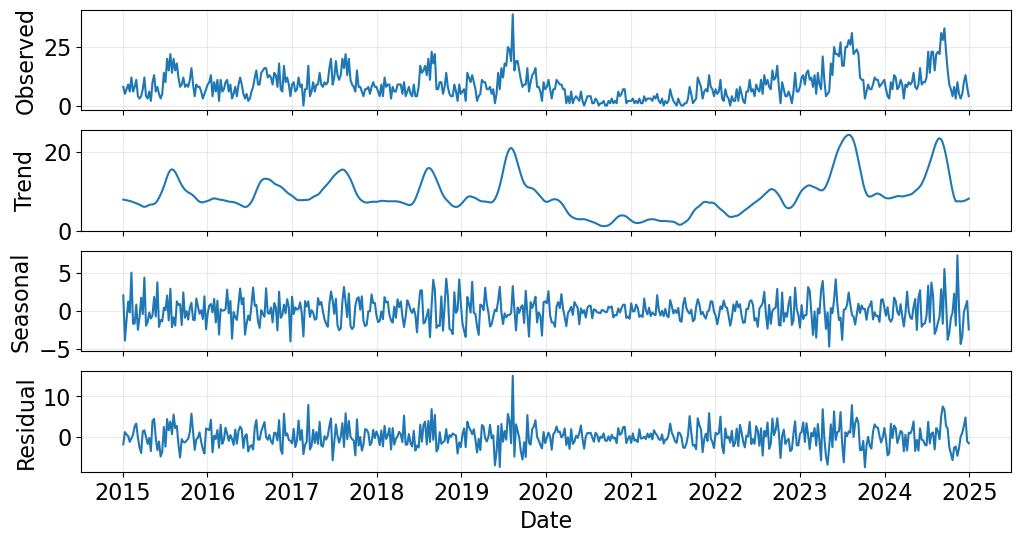

In [42]:
advanced_decomposition = STL(data_weekly_subset["Frequency"], period=8).fit()
advanced_decomposition

fig, axes = plt.subplots(nrows=4, figsize=(12,6), sharex=True)

axes[0].plot(data_weekly_subset.index, advanced_decomposition.observed)
axes[1].plot(data_weekly_subset.index, advanced_decomposition.trend)
axes[2].plot(data_weekly_subset.index, advanced_decomposition.seasonal)
axes[3].plot(data_weekly_subset.index, advanced_decomposition.resid)

axes[0].set_ylabel("Observed")
axes[1].set_ylabel("Trend")
axes[2].set_ylabel("Seasonal")
axes[3].set_ylabel("Residual")
axes[3].set_xlabel("Date")

for ax in axes:
  ax.grid("on")

plt.show(fig)

##### 4.1.3 `A09` Disease Monthly

In [43]:
data_monthly = df_A09.resample("M").agg({
    "Disease" : "first",
    "Frequency": "sum",
    "Average Age": "mean",
    "StdDev Age": "mean",
    "Subdistrict":"first"
})
data_monthly.head()

,Disease,Frequency,Average Age,StdDev Age,Subdistrict
Date,,,,,
2015-01-31,A09,34.0,21.162281,6.161291,4.0
2015-02-28,A09,36.0,25.333333,4.186209,5.0
2015-03-31,A09,25.0,26.421569,6.844382,2.0
2015-04-30,A09,21.0,24.523810,4.895726,3.0
2015-05-31,A09,38.0,25.198413,8.502820,3.0


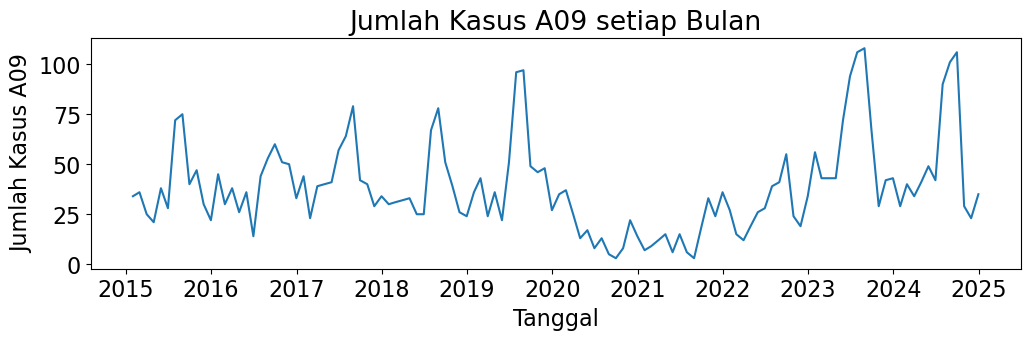

In [44]:
# plot the monthly counts
fig, ax = plt.subplots(figsize = (12,3))

ax.plot(data_monthly.index, data_monthly['Frequency'])

ax.set_xlabel('Tanggal')
ax.set_ylabel('Jumlah Kasus A09')
ax.set_title('Jumlah Kasus A09 setiap Bulan')

xticks = data_monthly.index[::12]
ax.set_xticks(xticks)

# ax.set_xticklabels([x.strftime('%Y-%m-%d') for x in xticks], rotation=45)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

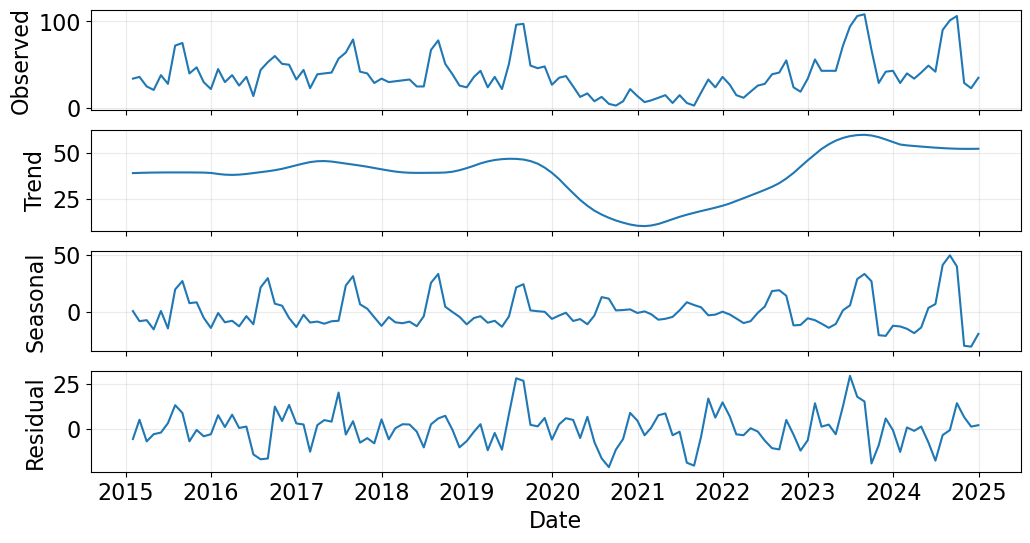

In [45]:
advanced_decomposition = STL(data_monthly['Frequency'], period=12).fit()
advanced_decomposition

fig, axes = plt.subplots(nrows=4, figsize=(12, 6), sharex=True)

axes[0].plot(data_monthly.index, advanced_decomposition.observed)
axes[1].plot(data_monthly.index, advanced_decomposition.trend)
axes[2].plot(data_monthly.index, advanced_decomposition.seasonal)
axes[3].plot(data_monthly.index, advanced_decomposition.resid)

axes[0].set_ylabel("Observed")
axes[1].set_ylabel("Trend")
axes[2].set_ylabel("Seasonal")
axes[3].set_ylabel("Residual")
axes[3].set_xlabel("Date")

for ax in axes:
  ax.grid("on")

plt.show(fig)

dalam interval bulanan, terjadi adanya tren naik di sepanjang pertengahan tahun, kemudian turun di akhir tahun.

- Proses Exploratory Data Analysis berguna untuk melihat pola pada data dalam waktu yang spesifik, yaitu daily, weekly, dan monthly.
- Hasil analisa dari tahap EDA digunakan untuk menentukan apakah perlu menggunakan metode statistik (mean, sum, median, std, quantile) sebelum masuk ke XGBoost Model.
- Hasil dari plot dekomposisi time series pada gambar yaitu terlihat adanya pola jangka panjang yang meningkat di awal kemudian sedikit menurun di akhir (tren). Serta, adanya pola musiman yang sangat jelas dengan periode harian, mingguan, atau tahunan (seasonal).
- Karena pola musiman sangat kuat, maka lag variables saja sudah cukup untuk menangkap pola ini tanpa harus menggunakan metode statistik.
- Metode statistik  sebaiknya dgunakan apabila ada pola mingguan yang berubah-ubah (misalnya, ada lonjakan di hari tertentu yang tidak konsisten).

# 5. Forecasting with XGBoost

## 5.1 Create Feature Engineering

In [46]:
def create_feature(data) :
    data = df_A09.copy()
    # data['Subdistrict'] = data['Subdistrict'].astype(int)
    data.index = pd.to_datetime(data.index) 

    data['day_of_week'] = data.index.dayofweek
    data['month'] = data.index.month
    data['day_of_year'] = data.index.dayofyear

    return data

def add_lags(data) : 

    window_size = 7  # Rolling window 7 hari
    rolling_features = data[['Frequency']].rolling(window=window_size).agg(['sum', 'mean', 'median', 'std'])
    rolling_features.columns = [f'rolling_{col}' for col in ['sum', 'mean', 'median', 'std']]
    
    data = pd.concat([data, rolling_features], axis=1)
    
    lag_days = [7, 14] 
    diseases = ["Frequency"] 

    for disease in diseases:
        for lag in lag_days:
            data[f'{disease}_lag_{lag}'] = data[disease].shift(lag)

    return data

In [47]:
data = df_A09.copy()
data = add_lags(create_feature(data))
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3649 entries, 2015-01-01 to 2024-12-27
Freq: D
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Disease           2312 non-null   object 
 1   Frequency         3649 non-null   float64
 2   Average Age       2312 non-null   float64
 3   StdDev Age        2312 non-null   float64
 4   Subdistrict       2312 non-null   float64
 5   day_of_week       3649 non-null   int32  
 6   month             3649 non-null   int32  
 7   day_of_year       3649 non-null   int32  
 8   rolling_sum       3643 non-null   float64
 9   rolling_mean      3643 non-null   float64
 10  rolling_median    3643 non-null   float64
 11  rolling_std       3643 non-null   float64
 12  Frequency_lag_7   3642 non-null   float64
 13  Frequency_lag_14  3635 non-null   float64
dtypes: float64(10), int32(3), object(1)
memory usage: 513.9+ KB


In [48]:
data.dtypes

Disease              object
Frequency           float64
Average Age         float64
StdDev Age          float64
Subdistrict         float64
day_of_week           int32
month                 int32
day_of_year           int32
rolling_sum         float64
rolling_mean        float64
rolling_median      float64
rolling_std         float64
Frequency_lag_7     float64
Frequency_lag_14    float64
dtype: object

## 5.2 Splitting Data

In [49]:
data.fillna(0, inplace=True)

def split_dataset(data, train_percentage, valid_percentage, features):
    total_data = len(data)
    train_size = int(train_percentage* total_data)
    valid_size = int(valid_percentage * total_data)
    test_size = total_data - (train_size + valid_size)

    train_data = data.iloc[:train_size].copy()
    valid_data = data.iloc[train_size:train_size + valid_size].copy()
    test_data = data.iloc[train_size + valid_size:].copy()

    # split the data into features and target variable
    X_train = train_data[features]
    y_train = train_data["Frequency"]

    X_valid = valid_data[features]
    y_valid = valid_data["Frequency"]
    
    X_test = test_data[features]
    y_test = test_data["Frequency"]
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [58]:
features = ['Average Age', 'StdDev Age', 'Subdistrict', 'day_of_week', 'month', 'day_of_year',
            'rolling_sum', 'rolling_mean', 'rolling_median', 'rolling_std','Frequency_lag_7', 
            'Frequency_lag_14']

# features = ['Average Age', 'StdDev Age', 'Subdistrict']

train_percentage = 0.8 # 80% Train
valid_percentage = 0.1  # 10% Validation
test_percentage = 0.1   # 10% Test

X_train, y_train, X_valid, y_valid, X_test, y_test = split_dataset(data, train_percentage, valid_percentage, features)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_valid:", X_valid.shape)  # Harus 12 fitur!
print("Shape of y_valid:", y_valid.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (2919, 12)
Shape of y_train: (2919,)
Shape of X_valid: (364, 12)
Shape of y_valid: (364,)
Shape of X_test: (366, 12)
Shape of y_test: (366,)


In [59]:
# cek rentang tanggal splitting data
date_range = pd.date_range(start="2015-01-01", end="2024-12-27")
split = pd.DataFrame({"Date": date_range})

train_size = 2919
valid_size = 364
test_size = 366

train_data = split.iloc[:train_size]
valid_data = split.iloc[train_size:train_size + valid_size]
test_data = split.iloc[train_size + valid_size:]

print(f"Train: {train_data.Date.iloc[0]} sampai {train_data.Date.iloc[-1]}")
print(f"Valid: {valid_data.Date.iloc[0]} sampai {valid_data.Date.iloc[-1]}")
print(f"Test: {test_data.Date.iloc[0]} sampai {test_data.Date.iloc[-1]}")

Train: 2015-01-01 00:00:00 sampai 2022-12-28 00:00:00
Valid: 2022-12-29 00:00:00 sampai 2023-12-27 00:00:00
Test: 2023-12-28 00:00:00 sampai 2024-12-27 00:00:00


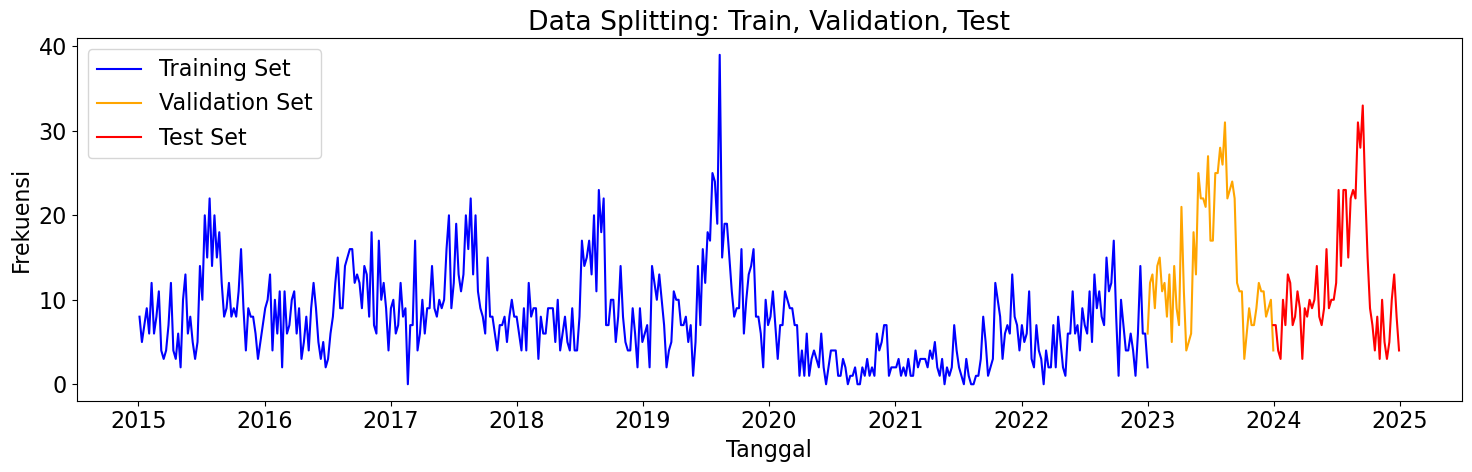

In [60]:
data.index = pd.to_datetime(data.index)

data['Frequency'] = pd.to_numeric(data['Frequency'], errors='coerce')

train_data = data.loc[:'2022-12-28']
valid_data = data.loc['2022-12-29':'2023-12-27']
test_data = data.loc['2023-12-28':]

# sampling data perminggu
train_weekly = train_data[['Frequency']].resample('W').sum()
valid_weekly = valid_data[['Frequency']].resample('W').sum()
test_weekly = test_data[['Frequency']].resample('W').sum()

fig, ax = plt.subplots(figsize=(15, 5), dpi=100)
ax.plot(train_weekly.index, train_weekly['Frequency'], label='Training Set', color='blue')
ax.plot(valid_weekly.index, valid_weekly['Frequency'], label='Validation Set', color='orange')
ax.plot(test_weekly.index, test_weekly['Frequency'], label='Test Set', color='red')

ax.set_title("Data Splitting: Train, Validation, Test")
ax.set_xlabel("Tanggal")
ax.set_ylabel("Frekuensi")
ax.legend()
plt.tight_layout()
plt.show()


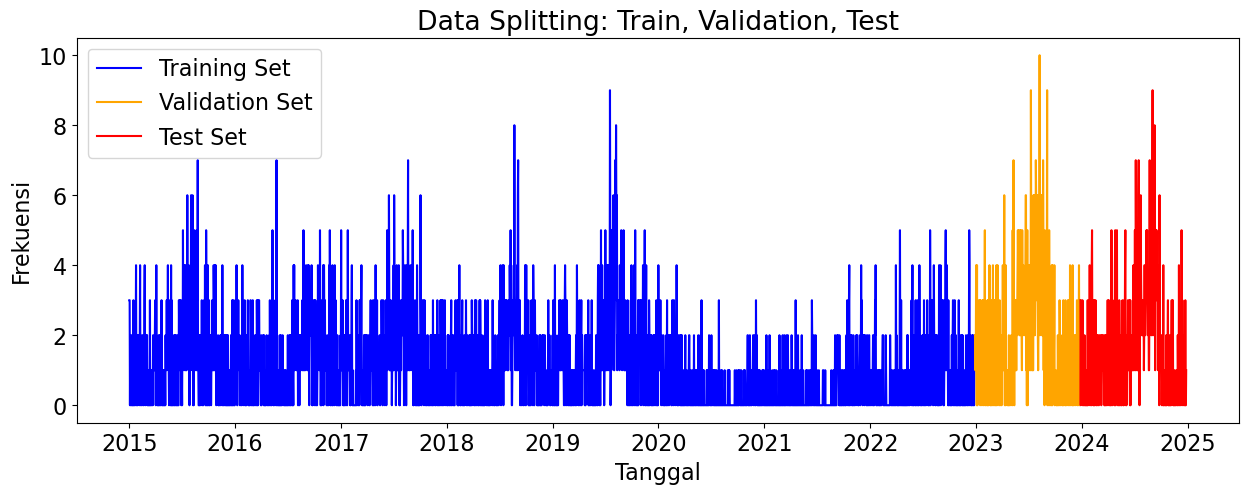

In [61]:
# plot splitting data
train_data = data.loc[:'2022-12-28']
valid_data = data.loc['2022-12-29':'2023-12-27']
test_data = data.loc['2023-12-28':]

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(train_data.index, train_data['Frequency'], label='Training Set', color='blue')
ax.plot(valid_data.index, valid_data['Frequency'], label='Validation Set', color='orange')
ax.plot(test_data.index, test_data['Frequency'], label='Test Set', color='red')

ax.set_title("Data Splitting: Train, Validation, Test")
ax.set_xlabel("Tanggal")
ax.set_ylabel("Frekuensi")
ax.legend()

plt.show()


In [62]:
data.describe()

,Frequency,Average Age,StdDev Age,Subdistrict,day_of_week,month,day_of_year,rolling_sum,rolling_mean,rolling_median,rolling_std,Frequency_lag_7,Frequency_lag_14
count,3649.000000,3649.000000,3649.000000,3649.000000,3649.000000,3649.000000,3649.000000,3649.000000,3649.000000,3649.000000,3649.000000,3649.000000,3649.000000
mean,1.261716,12.840817,4.702806,2.618526,3.000274,6.516306,182.951494,8.816662,1.259523,1.069060,1.045058,1.260071,1.257331
std,1.382561,18.073729,8.835365,2.346901,1.999794,3.446461,105.354176,6.125567,0.875081,0.974538,0.493957,1.382673,1.383186
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,92.000000,4.000000,0.571429,0.000000,0.755929,0.000000,0.000000
50%,1.000000,2.500000,0.000000,3.000000,3.000000,7.000000,183.000000,8.000000,1.142857,1.000000,0.975900,1.000000,1.000000
75%,2.000000,22.000000,4.000000,4.000000,5.000000,10.000000,274.000000,11.000000,1.571429,2.000000,1.272418,2.000000,2.000000
max,10.000000,94.000000,43.500000,7.000000,6.000000,12.000000,366.000000,39.000000,5.571429,6.000000,3.199702,10.000000,10.000000


# 6. Define the XGBoost Model and Perform Hyperparameter Tuning

In [63]:
baseline_model = xgb.XGBRegressor(
    tree_method='hist',
    objective='reg:squarederror',
    random_state=42
)
baseline_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [68]:
import shap

explainer = shap.Explainer(baseline_model, X_train)

shap_values = explainer(X_train)


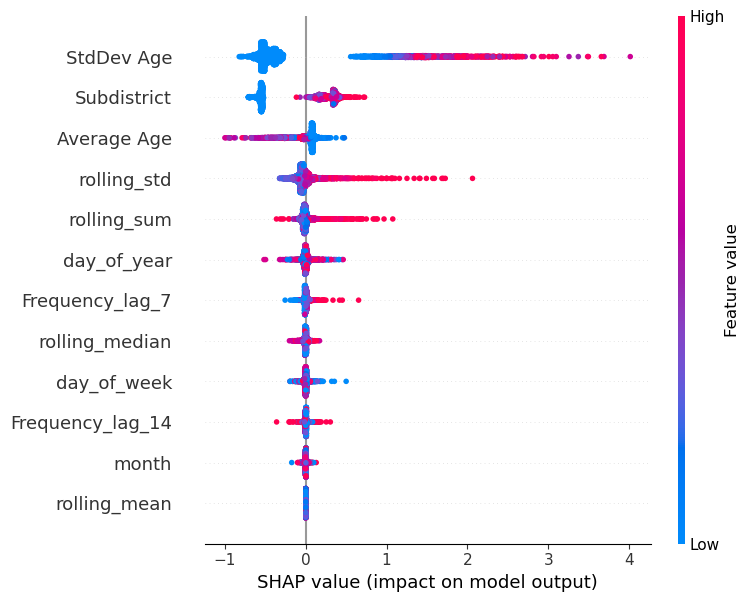

In [69]:
shap.summary_plot(shap_values, X_train)

# Feature Importance

In [64]:
feature_importance = pd.DataFrame(data=baseline_model.feature_importances_, index=baseline_model.feature_names_in_, columns=['importance'])
feature_importance

,importance
Average Age,0.015212
StdDev Age,0.497816
Subdistrict,0.280257
day_of_week,0.014541
month,0.008132
day_of_year,0.017609
rolling_sum,0.026046
rolling_mean,0.000000
rolling_median,0.030768
rolling_std,0.085471


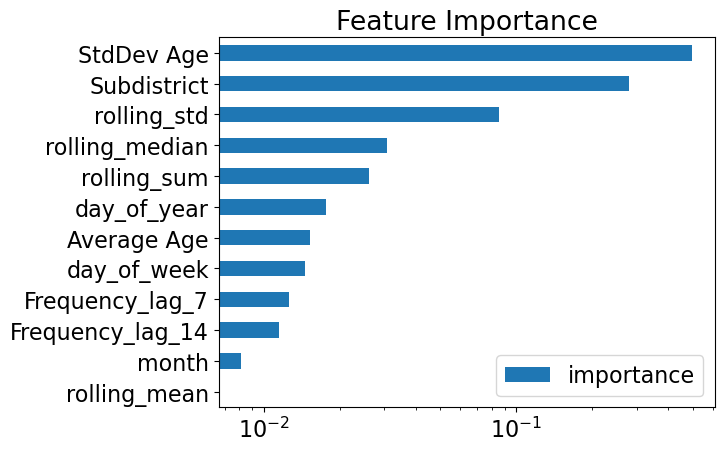

In [65]:
fig, ax = plt.subplots()
feature_importance.sort_values('importance').plot(kind='barh', title='Feature Importance', ax=ax)

ax.set_xscale("log")

plt.show()

In [89]:
y_pred = baseline_model.predict(X_valid)

nonzero_mask = y_valid != 0
if nonzero_mask.sum() > 0:
    mape = mean_absolute_percentage_error(y_valid[nonzero_mask], y_pred[nonzero_mask]) * 100
else:
    mape = float('inf')  

print(f"MAPE : {mape:.2f}%")

MAPE : 22.03%


fitur `rolling_mean` dibuang

In [134]:
# pilih fitur yang memiliki nilai penting di atas 0
top_features = feature_importance.sort_values(by='importance', ascending=False).head(11).index.tolist()

X_train_top = X_train[top_features]
X_valid_top = X_valid[top_features]

# tentukan opsi parameter yang akan dicari
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 5],
    'learning_rate': [0.01, 0.05],
    'reg_alpha': [0.01, 0.1],
    'reg_lambda': [0.01, 0.1]
}

# proses grid search
tscv = TimeSeriesSplit(n_splits=3)
model = xgb.XGBRegressor(tree_method='hist', objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1, # untuk efisiensi supaya lebih cepat
    verbose=1 # menampilkan informasi progress
)

grid_search.fit(X_train_top, y_train.to_numpy())

# pilih parameter terbaik dari hasil grid search
best_params = grid_search.best_params_
print("Best Parameters :", best_params)

# latih model dengan parameter terbaik ke seluruh data latih
best_model = xgb.XGBRegressor(
    tree_method='hist',
    objective='reg:squarederror',
    early_stopping_rounds=20, # jika dalam 20 iterasi tidak ada perbaikan pada validasi, training berhenti
    random_state=42,
    **best_params
)

best_model.fit(
    X_train_top, y_train,
    eval_set=[(X_valid_top, y_valid)],
    verbose=True
)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters : {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 0.01}
[0]	validation_0-rmse:1.91792
[1]	validation_0-rmse:1.85339
[2]	validation_0-rmse:1.79110
[3]	validation_0-rmse:1.73286
[4]	validation_0-rmse:1.67376
[5]	validation_0-rmse:1.62340
[6]	validation_0-rmse:1.57234
[7]	validation_0-rmse:1.52153
[8]	validation_0-rmse:1.47538
[9]	validation_0-rmse:1.43328
[10]	validation_0-rmse:1.39501
[11]	validation_0-rmse:1.35465
[12]	validation_0-rmse:1.31904
[13]	validation_0-rmse:1.28940
[14]	validation_0-rmse:1.25778
[15]	validation_0-rmse:1.22837
[16]	validation_0-rmse:1.20185
[17]	validation_0-rmse:1.17617
[18]	validation_0-rmse:1.15282
[19]	validation_0-rmse:1.13032
[20]	validation_0-rmse:1.10986
[21]	validation_0-rmse:1.09044
[22]	validation_0-rmse:1.07608
[23]	validation_0-rmse:1.06071
[24]	validation_0-rmse:1.04889
[25]	validation_0-rmse:1.03445
[26]	validation_0-rmse:1.

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

# 7. Train Using Time Series Walk Forward Validation

In [135]:
features = ['Average Age', 'StdDev Age', 'Subdistrict', 'day_of_week', 'day_of_year', 'month',
            'rolling_sum', 'rolling_median', 'rolling_std',
            'Frequency_lag_7', 'Frequency_lag_14']

train_end = "2022-12-28"  # Hari terakhir training
valid_start = "2022-12-29"
valid_end = "2023-12-27"
test_start = "2023-12-28"
test_end = "2024-12-27"

test_window = 14  # 2 minggu

all_predictions = pd.DataFrame(columns=["Actual_Frequency", "Predicted_Frequency"])
mape_scores = []

test_data = data.loc[test_start:test_end].copy()

# walk forward validation
for i in range(0, len(test_data) - test_window + 1, test_window):

    test = test_data.iloc[i:i+test_window]
    
    train_data = data.loc[:train_end].copy()
    valid_data = data.loc[valid_start:valid_end].copy()

    X_train = train_data[features]
    y_train = train_data['Frequency']
    
    X_valid = valid_data[features]
    y_valid = valid_data['Frequency']
    
    X_test = test[features]
    y_test = test['Frequency']
    
    best_model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False
    )

    # meramalkan data
    y_pred = best_model.predict(X_test)

    temp_df = pd.DataFrame({
        "Actual_Frequency": y_test.values,
        "Predicted_Frequency": y_pred
    }, index=y_test.index)
    
    all_predictions = pd.concat([all_predictions, temp_df])
    train_data = pd.concat([train_data, test])


In [46]:
all_predictions.head()

,Actual_Frequency,Predicted_Frequency
2023-12-28,3.0,2.785013
2023-12-29,0.0,0.011319
2023-12-30,2.0,2.791714
2023-12-31,2.0,2.974422
2024-01-01,1.0,1.108578


In [47]:
total_aktual = all_predictions["Actual_Frequency"].sum()
total_prediksi = all_predictions["Predicted_Frequency"].sum()
total_prediksi = np.ceil(total_prediksi)

print(f"Total Aktual: {total_aktual}")
print(f"Total Prediksi: {total_prediksi}")

Total Aktual: 625.0
Total Prediksi: 631.0


In [48]:
all_predictions.index = pd.to_datetime(all_predictions.index)
all_predictions['bulan'] = all_predictions.index.to_period('M')

monthly_sum = all_predictions.groupby('bulan').sum()
monthly_sum['Predicted_Frequency'] = np.ceil(monthly_sum['Predicted_Frequency'])

print(monthly_sum)

         Actual_Frequency  Predicted_Frequency
bulan                                         
2023-12               7.0                  9.0
2024-01              29.0                 30.0
2024-02              40.0                 42.0
2024-03              34.0                 36.0
2024-04              41.0                 40.0
2024-05              49.0                 50.0
2024-06              42.0                 44.0
2024-07              90.0                 98.0
2024-08             101.0                 93.0
2024-09             106.0                110.0
2024-10              29.0                 31.0
2024-11              23.0                 22.0
2024-12              34.0                 33.0


## 7.1 Plot the Results (After Validation)

In [136]:
# evaluasi MAPE (hindairn 0 supaya tidak error/infinity)
nonzero_mask = y_test != 0
if nonzero_mask.sum() > 0:
    mape = mean_absolute_percentage_error(y_test[nonzero_mask], y_pred[nonzero_mask]) * 100
else:
    mape = float('inf')  

print(f"MAPE: {mape:.2f}%")

MAPE: 14.89%


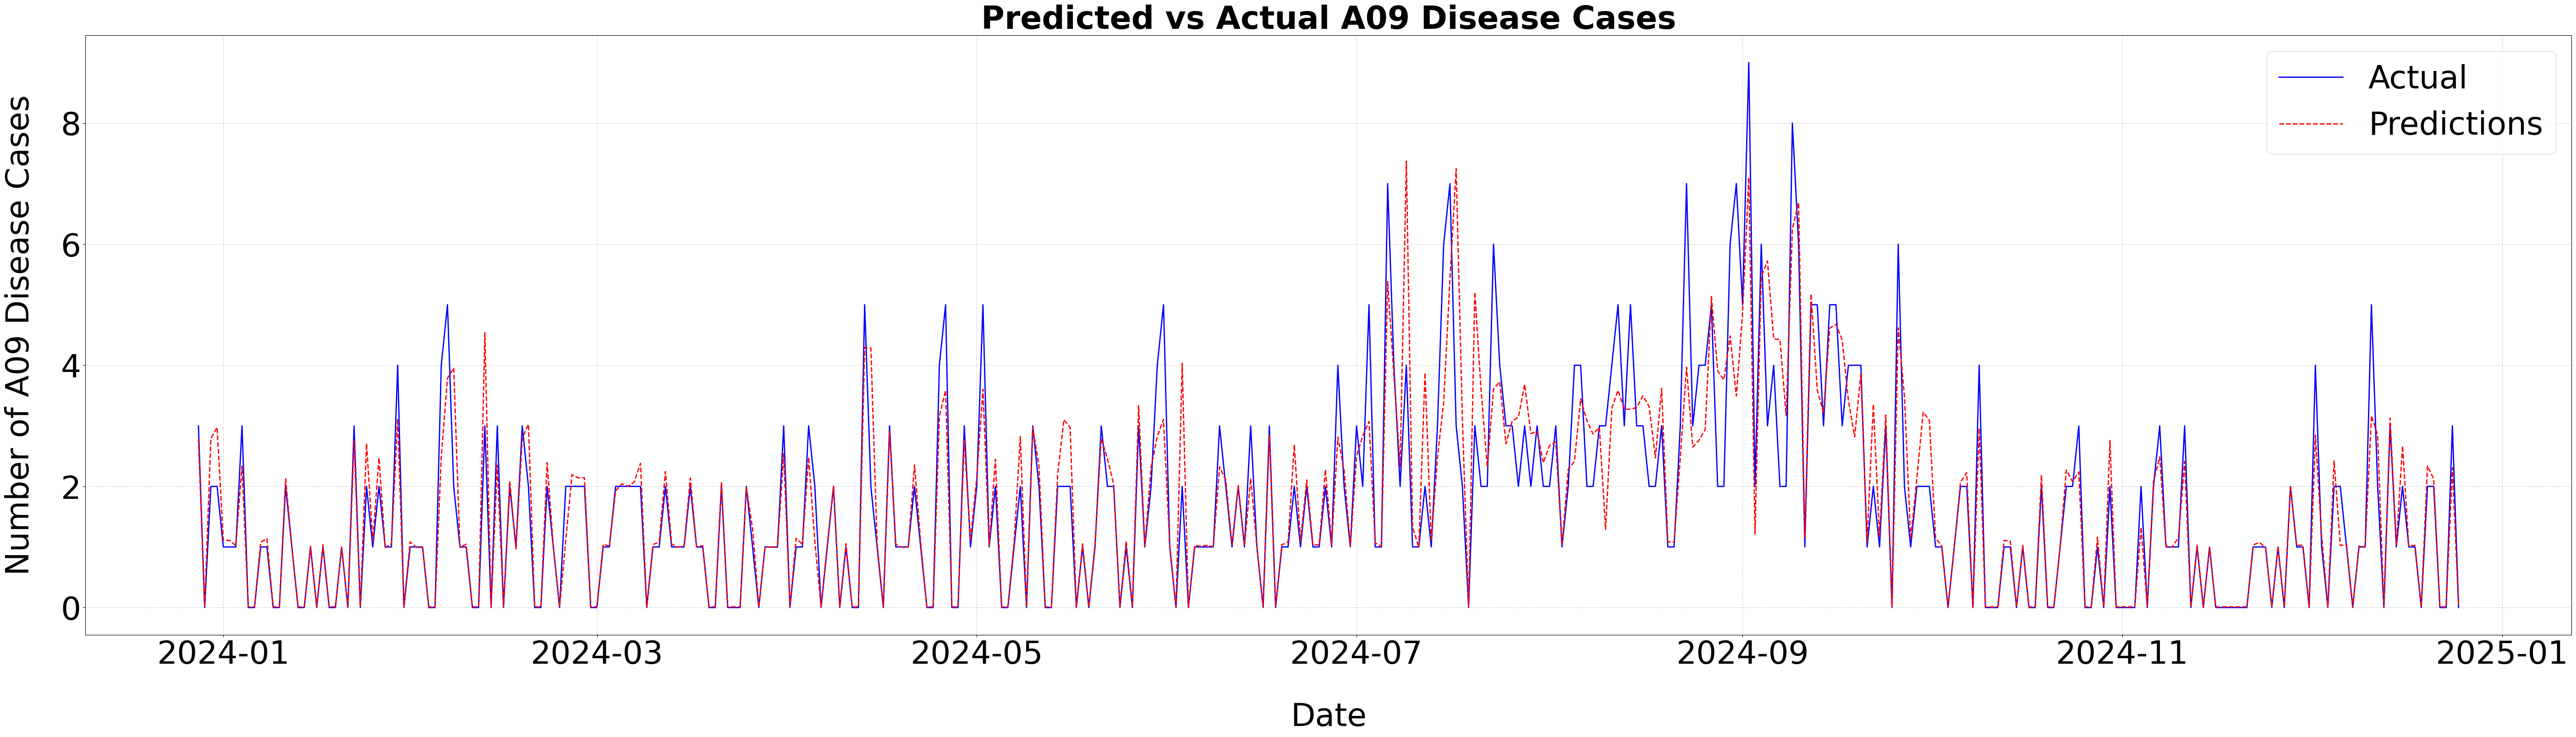

In [66]:
fig, ax = plt.subplots(figsize=(70, 17), dpi=100)

ax.plot(all_predictions.index, all_predictions["Actual_Frequency"], label="Actual", color="blue", linewidth=2)

ax.plot(all_predictions.index, all_predictions["Predicted_Frequency"], label="Predictions", color="red", linestyle="dashed", linewidth=2)

ax.set_ylabel("Number of A09 Disease Cases", fontsize=50, labelpad=40)
ax.set_xlabel("Date", fontsize=50, labelpad=50)
ax.set_title("Predicted vs Actual A09 Disease Cases", fontsize=50, fontweight="bold", )

ax.tick_params(axis='x', labelsize=50)
ax.tick_params(axis='y', labelsize=50)

ax.grid(True, linestyle="--", alpha=0.6)
ax.legend(fontsize=50)

plt.show()

In [52]:
all_predictions.index = pd.to_datetime(all_predictions.index, errors="coerce")
all_predictions.to_csv("all_predictions_A09_disease.csv", index=True)

# 8. Preparing to Predict the Future

In [ ]:
predict = data.copy()

FEATURES = ['Average Age', 'StdDev Age', 'Subdistrict', 'day_of_week', 'day_of_year', 'month', 
            'rolling_sum', 'rolling_median', 'rolling_std',
            'Frequency_lag_7', 'Frequency_lag_14']

TARGET = 'Frequency'

X_all = predict[FEATURES]
y_all = predict[TARGET]

# retrain seluruh dataset
best_model.fit(X_all, y_all, eval_set=[(X_all, y_all)], verbose=100)

[0]	validation_0-rmse:1.32314


[100]	validation_0-rmse:0.34771
[199]	validation_0-rmse:0.28968


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [197]:
predict.index.max()

Timestamp('2024-12-27 00:00:00')

In [198]:
future = pd.date_range('2024-12-27', '2025-05-31', freq='D')
future_df = pd.DataFrame(index=future)

future_df['isFuture'] = True # rentang tanggal untuk masa depan (tanggal yang harus diprediksi)
predict['isFuture'] = False 

df_and_future = pd.concat([predict, future_df])

In [199]:
future_with_features = df_and_future.query('isFuture').copy()

In [201]:
predict.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3649 entries, 2015-01-01 to 2024-12-27
Freq: D
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Disease           3649 non-null   object 
 1   Frequency         3649 non-null   float64
 2   Average Age       3649 non-null   float64
 3   StdDev Age        3649 non-null   float64
 4   Subdistrict       3649 non-null   float64
 5   day_of_week       3649 non-null   int32  
 6   month             3649 non-null   int32  
 7   day_of_year       3649 non-null   int32  
 8   rolling_sum       3649 non-null   float64
 9   rolling_mean      3649 non-null   float64
 10  rolling_median    3649 non-null   float64
 11  rolling_std       3649 non-null   float64
 12  Frequency_lag_7   3649 non-null   float64
 13  Frequency_lag_14  3649 non-null   float64
 14  isFuture          3649 non-null   bool   
dtypes: bool(1), float64(10), int32(3), object(1)
memory usage: 517.

# 10. Predict the Future

In [202]:
future_with_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 156 entries, 2024-12-27 to 2025-05-31
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Disease           0 non-null      object 
 1   Frequency         0 non-null      float64
 2   Average Age       0 non-null      float64
 3   StdDev Age        0 non-null      float64
 4   Subdistrict       0 non-null      float64
 5   day_of_week       0 non-null      float64
 6   month             0 non-null      float64
 7   day_of_year       0 non-null      float64
 8   rolling_sum       0 non-null      float64
 9   rolling_mean      0 non-null      float64
 10  rolling_median    0 non-null      float64
 11  rolling_std       0 non-null      float64
 12  Frequency_lag_7   0 non-null      float64
 13  Frequency_lag_14  0 non-null      float64
 14  isFuture          156 non-null    bool   
dtypes: bool(1), float64(13), object(1)
memory usage: 18.4+ KB


In [ ]:
def forecasting(future_with_features, best_model):
    features = ['Average Age', 'StdDev Age', 'Subdistrict', 'day_of_week', 'day_of_year', 'month',
            'rolling_sum', 'rolling_median', 'rolling_std',
            'Frequency_lag_7', 'Frequency_lag_14']
    
    future_with_features = future_with_features.copy()
    
    for i in range(len(future_with_features)): # melakukan perulangan pada setiap bris data
        # mengambil nilai pada fitur input dari baris ke-i
        input_features = future_with_features.loc[future_with_features.index[i], features].values.reshape(1, -1)
        
        # melakukan prediksi menggunakan best model
        predicted_value = best_model.predict(input_features)[0]  
        
        # hasil prediksinya dimasukkan ke kolom frekuensi
        future_with_features.at[future_with_features.index[i], 'Frequency'] = predicted_value
        
        # perbarui nilai lag dan rolling statistik
        if i + 7 < len(future_with_features):
            future_with_features.at[future_with_features.index[i + 7], 'Frequency_lag_7'] = predicted_value
        if i + 14 < len(future_with_features):
            future_with_features.at[future_with_features.index[i + 14], 'Frequency_lag_14'] = predicted_value
    
        if i >= 7:
            window_data = future_with_features['Frequency'].iloc[:i+1].rolling(7)
            future_with_features.at[future_with_features.index[i], 'rolling_median'] = window_data.median().iloc[-1]
            future_with_features.at[future_with_features.index[i], 'rolling_std'] = window_data.std().iloc[-1]
            future_with_features.at[future_with_features.index[i], 'rolling_sum'] = window_data.sum().iloc[-1]

    return future_with_features

In [213]:
future_with_predictions = forecasting(future_with_features, best_model)

print(future_with_predictions[['Frequency']].head(20))

            Frequency
2024-12-27   5.661448
2024-12-28   5.661448
2024-12-29   5.661448
2024-12-30   5.661448
2024-12-31   5.661448
2025-01-01   5.661448
2025-01-02   5.661448
2025-01-03   5.615148
2025-01-04   5.615148
2025-01-05   5.615148
2025-01-06   5.615148
2025-01-07   5.615148
2025-01-08   5.615148
2025-01-09   5.615148
2025-01-10   5.580776
2025-01-11   5.580776
2025-01-12   5.580776
2025-01-13   5.580776
2025-01-14   5.580776
2025-01-15   5.580776


In [214]:
future_with_predictions

,Disease,Frequency,Average Age,StdDev Age,Subdistrict,day_of_week,month,day_of_year,rolling_sum,rolling_mean,rolling_median,rolling_std,Frequency_lag_7,Frequency_lag_14,isFuture
2024-12-27,NaN,5.661448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2024-12-28,NaN,5.661448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2024-12-29,NaN,5.661448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2024-12-30,NaN,5.661448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2024-12-31,NaN,5.661448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-27,NaN,5.580776,NaN,NaN,NaN,NaN,NaN,NaN,39.065434,NaN,5.580776,0.0,5.580776,5.580776,True
2025-05-28,NaN,5.580776,NaN,NaN,NaN,NaN,NaN,NaN,39.065434,NaN,5.580776,0.0,5.580776,5.580776,True
2025-05-29,NaN,5.580776,NaN,NaN,NaN,NaN,NaN,NaN,39.065434,NaN,5.580776,0.0,5.580776,5.580776,True
2025-05-30,NaN,5.580776,NaN,NaN,NaN,NaN,NaN,NaN,39.065434,NaN,5.580776,0.0,5.580776,5.580776,True


hasilnya nanti dibulatkan ke atas. lebih baik over estimate untuk jumlah pasien. 

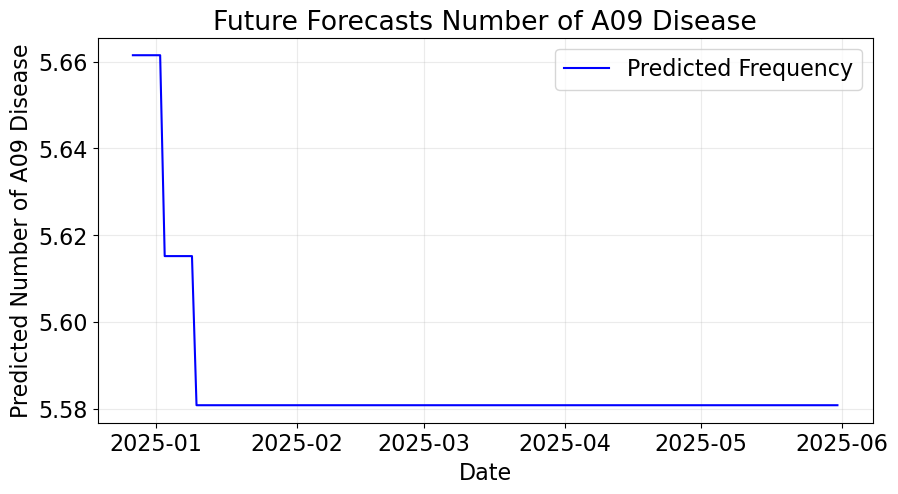

In [215]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(future_with_predictions.index, future_with_predictions['Frequency'], label='Predicted Frequency', color='blue')
ax.set_xlabel('Date')
ax.set_ylabel('Predicted Number of A09 Disease')
ax.set_title('Future Forecasts Number of A09 Disease')
ax.legend()
ax.grid()

plt.show()

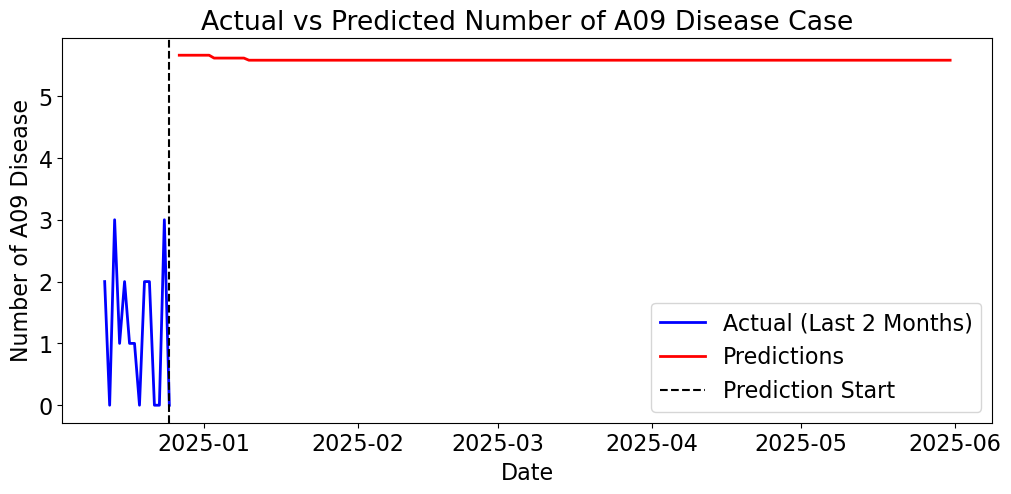

In [217]:
last_2_months_actual = y_test.last("2M")

future_dates = future_with_predictions.index
future_values = future_with_predictions['Frequency']

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(last_2_months_actual.index, last_2_months_actual, label = "Actual (Last 2 Months)", color="blue", linewidth=2)
ax.plot(future_dates, future_values, label="Predictions", color="red", linewidth=2)

ax.set_xlabel("Date")
ax.set_ylabel("Number of A09 Disease")
ax.set_title("Actual vs Predicted Number of A09 Disease Case")
ax.axvline(x=last_2_months_actual.index[-1], color="black", linestyle="--", label="Prediction Start")
ax.legend()

plt.show()



In [218]:
future_with_predictions.index = pd.to_datetime(future_with_predictions.index)
monthly_predictions = future_with_predictions.resample('M').sum()
monthly_predictions['Frequency'] = np.ceil(monthly_predictions['Frequency']) # bulatkan ke atas

monthly_predictions["Frequency"]

2024-12-31     29.0
2025-01-31    174.0
2025-02-28    157.0
2025-03-31    174.0
2025-04-30    168.0
2025-05-31    174.0
Freq: M, Name: Frequency, dtype: float64

In [219]:
monthly_predictions["Frequency"].sum()

876.0

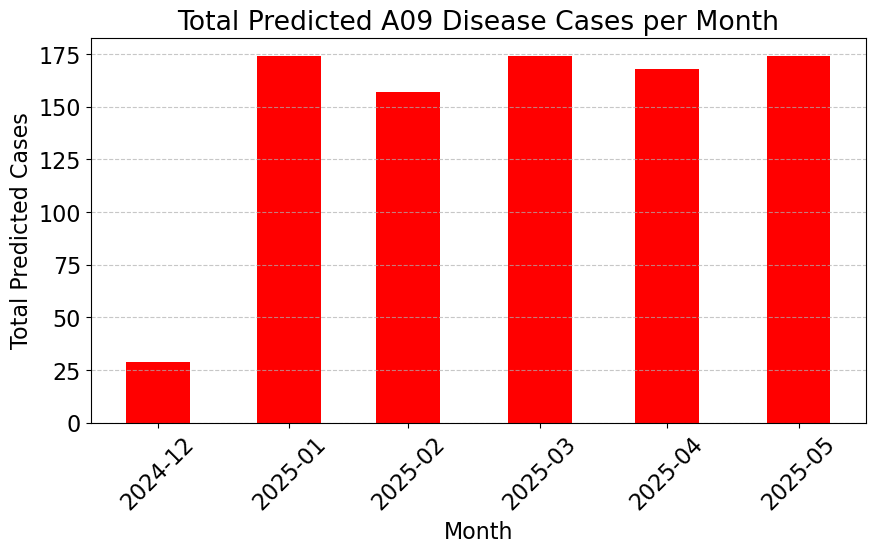

In [220]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(monthly_predictions.index, 
       monthly_predictions['Frequency'], 
       color='red', 
       label='Predicted Cases', 
       width=15)  

ax.set_xlabel('Month')
ax.set_ylabel('Total Predicted Cases')
ax.set_title('Total Predicted A09 Disease Cases per Month')
ax.set_xticks(monthly_predictions.index)
ax.set_xticklabels(monthly_predictions.index.strftime('%Y-%m'), rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [68]:
# monthly_predictions.to_csv('predicted_A09_disease.csv', index=True)

In [ ]:
# future_with_predictions[["Frequency"]].to_csv('predicted_A09_disease.csv', index=True)